In [1]:

import os 
import numpy as np
import torch
import torch.nn as nn 
import random
import matplotlib.pyplot as plt 
import skimage 
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio
from tqdm import tqdm
import wandb
from deepinv.physics import Tomography, Downsampling

from torch.func import jvp, functional_call, jacrev


from operator_module import OperatorModule

from model.unet import get_unet_model



In [2]:
cfg = {
    "forward_operator": "radon",  #"downsampling", # "radon"
    "lr": 1e-4,
    "num_angles": 90,
    "rel_noise": 0.05,
    "num_epochs": 10000,
    "img_log_freq": 100,
    "model_params": {
        "use_norm": False,
        "scales": 5,
        "use_sigmoid": False,
        "skip": 16,
        "channels": (32, 64, 128, 128, 256, 256),
        "activation" : "relu" # "silu"
    },
    "model_inp": "fbp", # "random" "fbp"
    "inp_noise": 0.05,
    "optimiser": "adam", # "lbfgs" "adam" "gd" #amsgrad # "rmsprop"
    "betas": (0.9, 0.999),
    "momentum" : 0.0,
    "weight_decay": 0.0,
    "tv_reg": 4e-4
    ,
    "tv_type": "anisotropic"
}

In [3]:

#device = "cuda:1"
device = "cpu"
# If I set torch.manuel_seed it is still random 
torch.manual_seed(1)

#model = get_unet_model(use_norm=cfg["model_params"]["use_norm"], 
#                        scales=cfg["model_params"]["scales"],
#                        use_sigmoid=cfg["model_params"]["use_sigmoid"], 
#                        skip=cfg["model_params"]["skip"],
#                        channels=cfg["model_params"]["channels"])


class SimpleCNN(nn.Module):
    def __init__(self, input_channels):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers with padding to maintain input shape
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)  # 3x3 kernel, stride=1, padding=1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        
        # Final layer to restore the input channel count
        self.conv4 = nn.Conv2d(16, input_channels, kernel_size=3, stride=1, padding=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)  # No activation here to keep output flexible
        return x

model = SimpleCNN(input_channels=1)
model.to(device)

x = torch.load("walnut.pt")
x = x.float().to(device)

x = torch.nn.functional.interpolate(x, size=(128,128))

print("x: ", x.shape)

A = Tomography(angles=cfg["num_angles"], img_width=128, device=device) 
A = OperatorModule(A)

y = A(x)
print("noise std: ", cfg["rel_noise"]*torch.mean(y.abs()))
y_noise = y + cfg["rel_noise"]*torch.mean(y.abs())*torch.randn_like(y)
x_fbp = A.A_dagger(y_noise) 
print(y.shape, y_noise.shape)

print("Number of parameters: ", sum([p.numel() for p in model.parameters()]))
if cfg["model_inp"] == "fbp":
    z = x_fbp
else:
    z = torch.randn(x.shape)

z = z.to(device)
y_noise = y_noise.to(device)

with torch.no_grad():
    x_pred = model(z)


x:  torch.Size([1, 1, 128, 128])
noise std:  tensor(0.4528)
torch.Size([1, 1, 182, 90]) torch.Size([1, 1, 182, 90])
Number of parameters:  9569


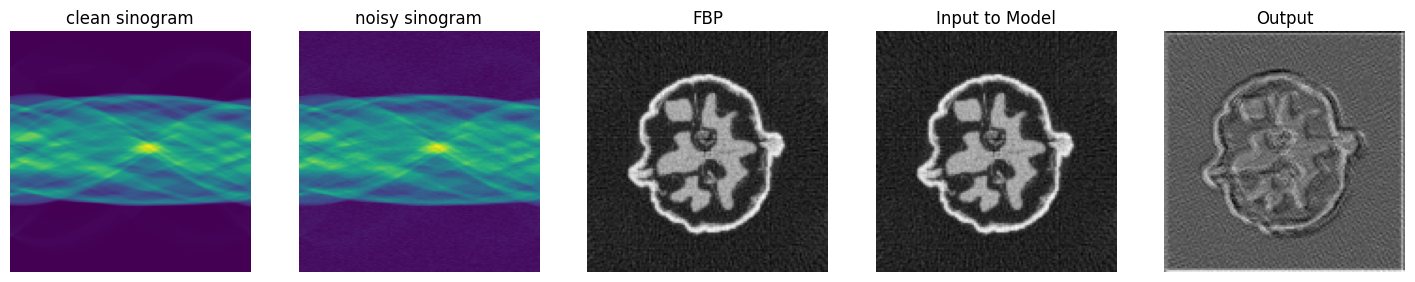

In [4]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(18,6))

ax1.imshow(y[0,0,:,:].cpu().numpy())
ax1.set_title("clean sinogram")
ax1.axis("off")
ax1.set_aspect(y.shape[-1] / y.shape[-2]) 

ax2.imshow(y_noise[0,0,:,:].cpu().numpy())
ax2.set_title("noisy sinogram")
ax2.axis("off")
ax2.set_aspect(y.shape[-1] / y.shape[-2]) 

ax3.imshow(x_fbp[0,0,:,:].cpu().numpy(), cmap="gray")
ax3.set_title("FBP")
ax3.axis("off")

ax4.imshow(z[0,0,:,:].cpu().numpy(), cmap="gray")
ax4.set_title("Input to Model")
ax4.axis("off")

ax5.imshow(x_pred[0,0,:,:].cpu().numpy(), cmap="gray")
ax5.set_title("Output")
ax5.axis("off")


plt.show()


In [5]:

 

theta_0 = dict(model.named_parameters())
#forward_pass = functional_call(model, theta_0, z)

#x_pred = model(z)

#def model_forward(*theta):
#    return functional_call(model, theta, z)



#(output, jvp_out) = torch.func.jvp(model_forward, (theta_0,), (theta_0,))

#(_, vjpfunc) = torch.func.vjp(model_forward, theta_0)


#print(jvp_out)
#print(output.shape, jvp_out.shape)


#jacobians = jacrev(functional_call, argnums=0)(model, theta_0, (z, ))

#print(jacobians.shape)

#x_pred = model(z)
#loss = torch.mean((A(x_pred) - y_noise)**2) 
#loss.backward() 

#row_index= 0

#input_dim = sum(p.numel() for p in theta_0.values())  # Total number of parameters
#v = torch.zeros(input_dim)
#v[row_index] = 1.0

# Compute the JVP
#jvp_out, _ = torch.func.jvp(model_forward, (theta_0,), (v,))

# jvp_out contains the desired row of the Jacobian matrix
#print(jvp_out)

In [6]:
import torch
from torch.func import jvp, functional_call

def model_forward(theta):
    return functional_call(model, theta, z)

def get_jacobian_row(row_index):
    
    # Flatten theta_0 to compute input dimension
    flat_params = torch.cat([p.flatten() for p in theta_0.values()])
    input_dim = flat_params.numel()  # Total number of parameters
    
    # Create a one-hot vector for the desired row
    v_flat = torch.zeros(input_dim)
    v_flat[row_index] = 1.0
    
    # Unflatten the one-hot vector to match the structure of theta_0
    v_struct = {}
    start = 0
    for key, param in theta_0.items():
        numel = param.numel()
        v_struct[key] = v_flat[start:start + numel].view_as(param)
        start += numel

    #print(theta_0)
    #print(v_struct)
    # Compute the JVP
    out, jvp_out = jvp(model_forward, (theta_0,), (v_struct,))
    
    return jvp_out.detach()


In [7]:
jac_row = get_jacobian_row(10)
print(jac_row.shape)

torch.Size([1, 1, 128, 128])


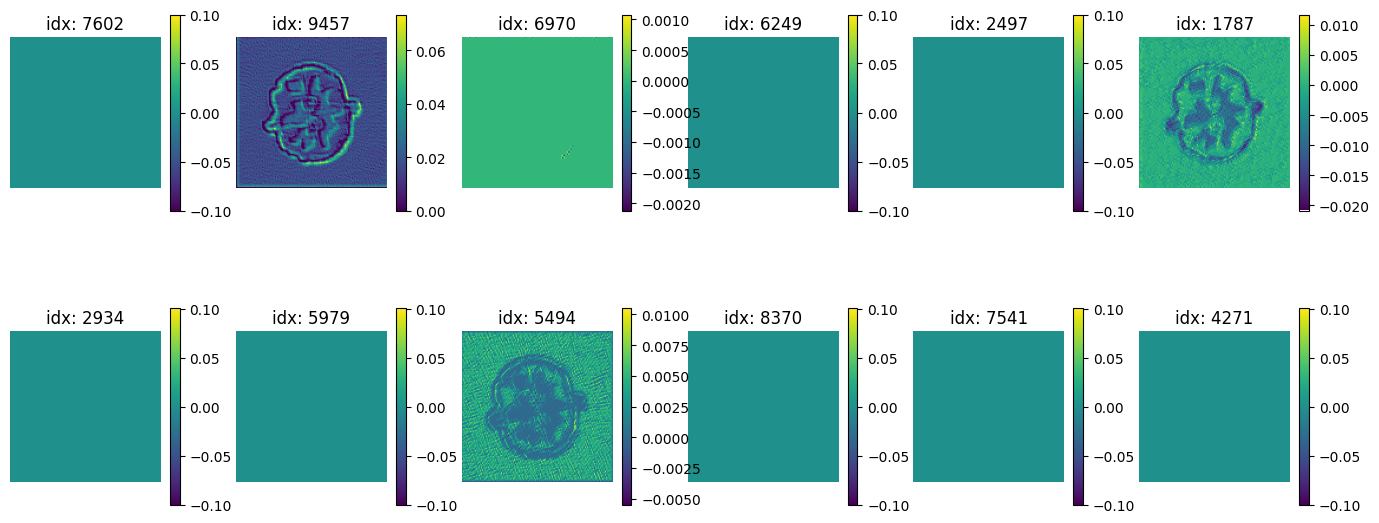

In [8]:
fig, axes = plt.subplots(2,6, figsize=(17,7))

for idx, ax in enumerate(axes.ravel()):
    row_idx = np.random.randint(9569)
    jac_row = get_jacobian_row(row_idx)
    im = ax.imshow(jac_row[0,0].cpu().numpy())
    fig.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title(f"idx: {row_idx}")
    ax.axis("off")
plt.show()

In [9]:
jac_row = get_jacobian_row(0)
jac_row2 =  get_jacobian_row(10)

print(torch.sum((jac_row - jac_row2)**2))

tensor(0.1337)


In [10]:
flat_params = torch.cat([p.flatten() for p in theta_0.values()])
input_dim = flat_params.numel()  # Total number of parameters

print(input_dim)

9569


In [11]:
import torch
from torch.func import jacrev

theta_0 = dict(model.named_parameters())

# Example function: Replace with your model's forward pass
def model_forward(params, inputs):
    
    # Unflatten the one-hot vector to match the structure of theta_0
    params_struct = {}
    start = 0
    for key, param in theta_0.items():
        numel = param.numel()
        params_struct[key] = params[start:start + numel].view_as(param)
        start += numel

    
    return functional_call(model, params_struct, inputs)

# Example inputs
params = dict(model.named_parameters())  # Replace with your model's parameters
flat_params = torch.cat([p.flatten() for p in params.values()])
# Compute the Jacobian matrix

jacobian = jacrev(model_forward, argnums=0, chunk_size=1)(flat_params, z)


In [12]:
jacobian.shape

torch.Size([1, 1, 128, 128, 9569])

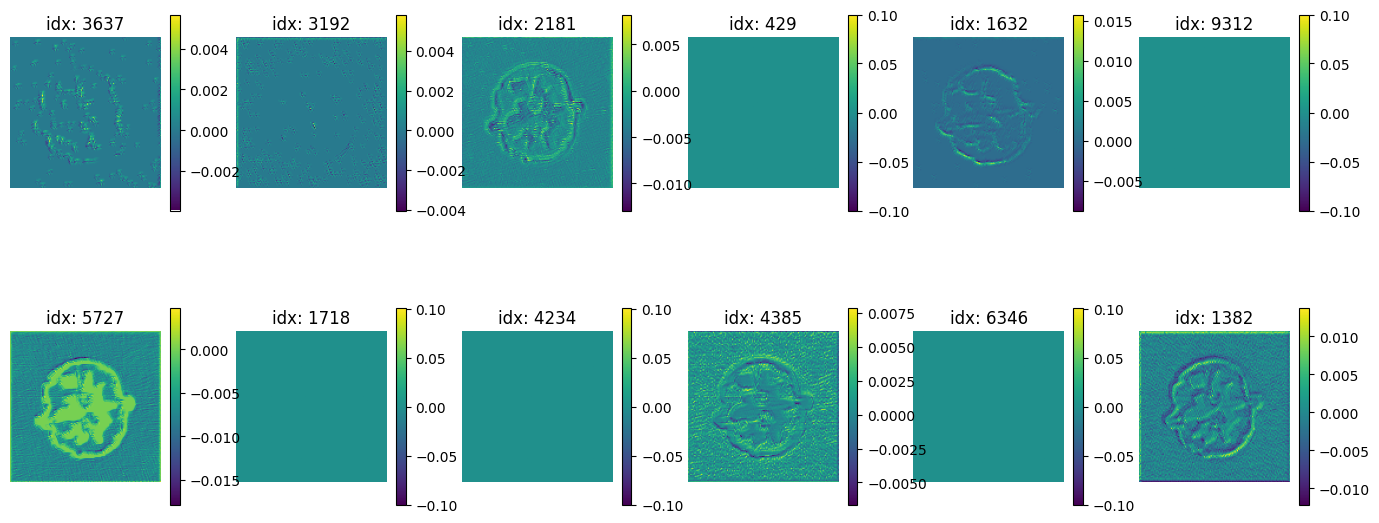

In [13]:
fig, axes = plt.subplots(2,6, figsize=(17,7))

for idx, ax in enumerate(axes.ravel()):
    row_idx = np.random.randint(9569)
    im = ax.imshow(jacobian[0,0,:,:,row_idx].detach().cpu().numpy())
    fig.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title(f"idx: {row_idx}")
    ax.axis("off")
plt.show()

In [14]:

print("jacobian shape: ", jacobian.shape) # should be 128^2 x 9569 

# Flatten the Jacobian if needed (e.g., for images or higher-dimensional outputs)
jacobian_flat = jacobian.view(-1, jacobian.shape[-1])

# Perform SVD
U, S, Vh = torch.linalg.svd(jacobian_flat)

# U contains left singular vectors
# S contains singular values
# Vh (V^T) contains right singular vectors (transposed)
print("Singular values:", S.shape)
print("Left singular vectors (U):", U.shape)
print("Right singular vectors (V^T):", Vh.shape)


jacobian shape:  torch.Size([1, 1, 128, 128, 9569])
Singular values: torch.Size([9569])
Left singular vectors (U): torch.Size([16384, 16384])
Right singular vectors (V^T): torch.Size([9569, 9569])


In [15]:
S.shape

torch.Size([9569])

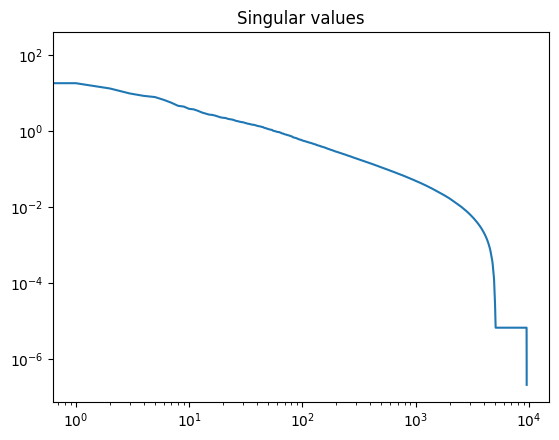

In [16]:
plt.figure()
plt.title("Singular values")
plt.loglog(S.detach().cpu().numpy())
plt.show()

In [17]:
U.shape, Vh.shape

(torch.Size([16384, 16384]), torch.Size([9569, 9569]))

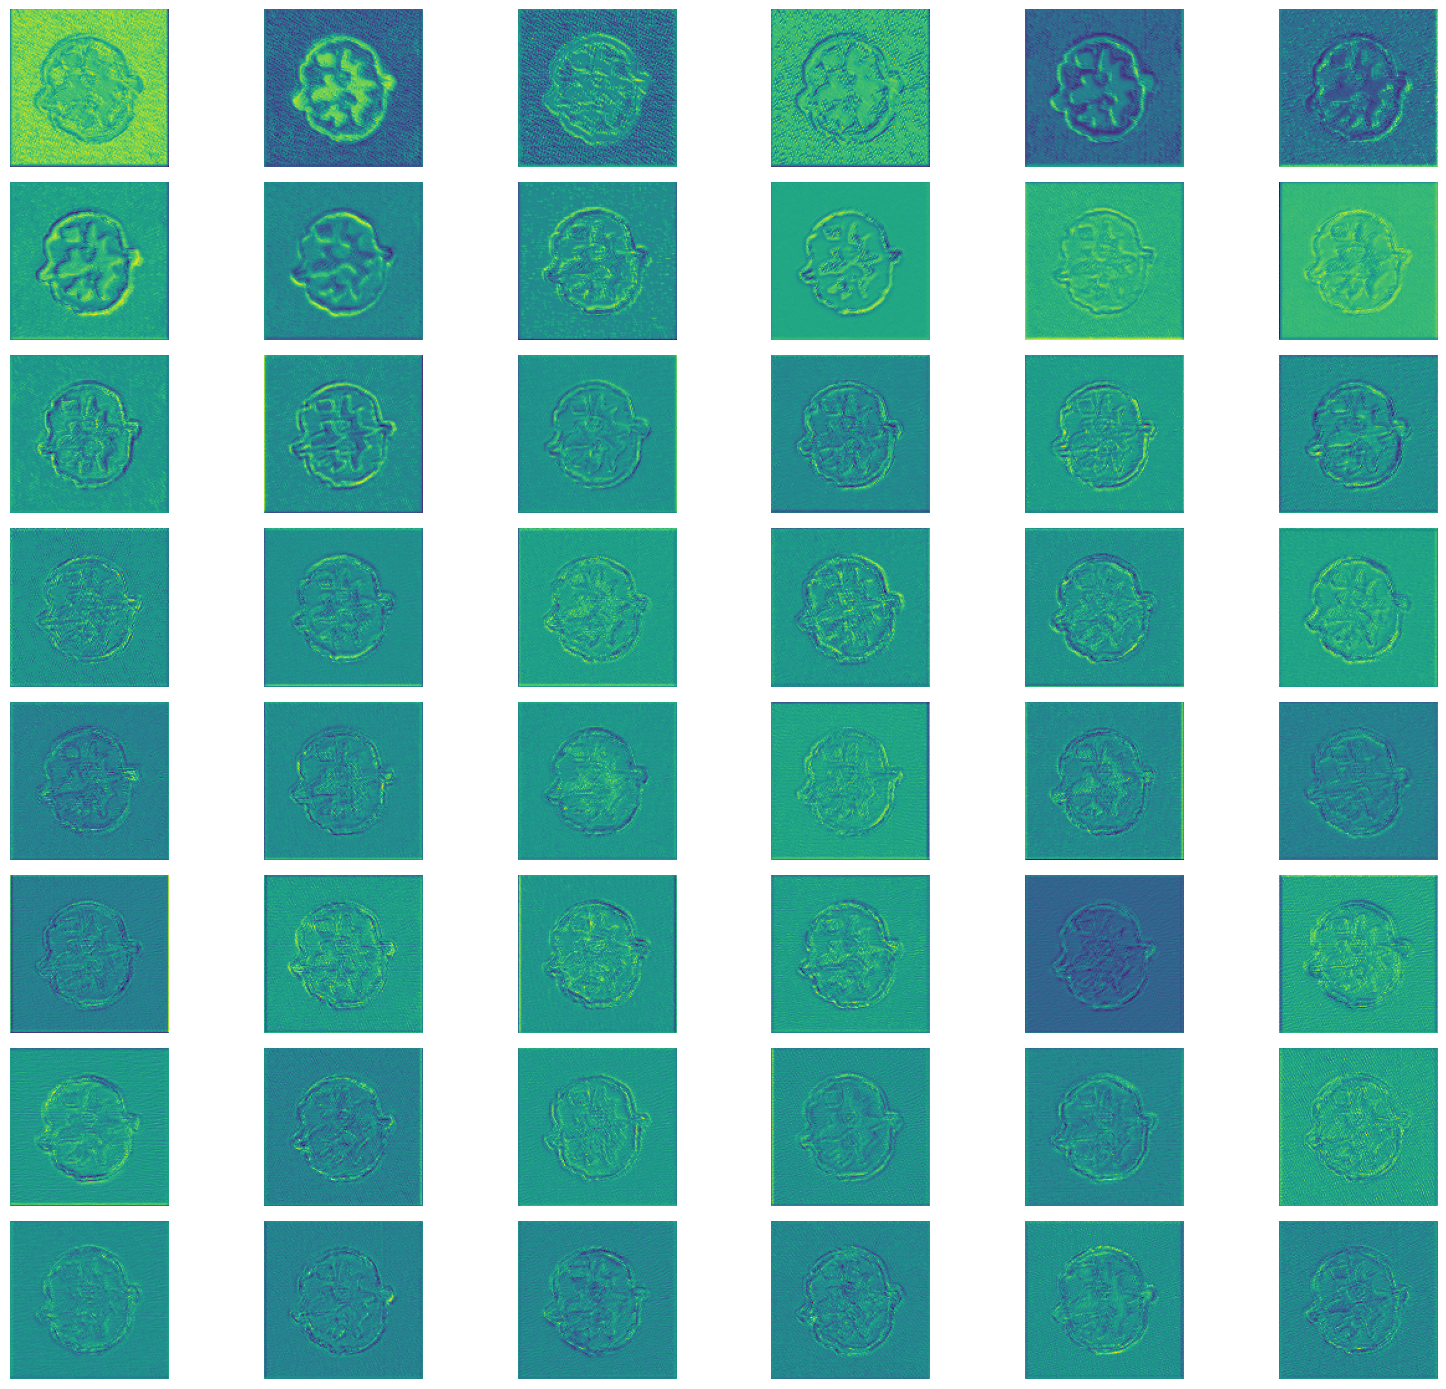

In [18]:
fig, axes = plt.subplots(8,6, figsize=(16,14))

for idx, ax in enumerate(axes.ravel()):
    ax.imshow(U[:,idx].reshape(128,128).detach().cpu().numpy())
    ax.axis("off")
fig.tight_layout()
plt.show()

In [19]:
jacobian_flat.shape

torch.Size([16384, 9569])

In [20]:
first_singular_value = S[0]
first_left_vector = U[:, 0]
first_right_vector = Vh[0, :]

# Compute the action of J on the first right singular vector
J_dot_v1 = jacobian_flat @ first_right_vector

# Verify that it is equal to the first singular value times the first left singular vector
test_result = torch.sum((J_dot_v1 - first_singular_value * first_left_vector)**2)

print("First singular value:", first_singular_value)
print("Verification successful:", test_result)

First singular value: tensor(148.5080, grad_fn=<SelectBackward0>)
Verification successful: tensor(2.9384e-06, grad_fn=<SumBackward0>)


In [21]:
first_singular_value = S[0]
first_left_vector = U[:, 0]
first_right_vector = Vh[0, :]

# Compute the action of J on the first right singular vector
JT_dot_u1 = jacobian_flat.T @ first_left_vector

# Verify that it is equal to the first singular value times the first left singular vector
test_result = torch.sum((JT_dot_u1 - first_singular_value * first_right_vector)**2)

print("First singular value:", first_singular_value)
print("Verification successful:", test_result)

First singular value: tensor(148.5080, grad_fn=<SelectBackward0>)
Verification successful: tensor(7.3218e-06, grad_fn=<SumBackward0>)


In [45]:
# can we represent x using the (left) singular vectors? 

rel_errors = []

x_svd = 0 
for i in range(U.shape[1]):
    x_svd += torch.dot(x.ravel(), U[:,i]) * U[:,i]

    rel_errors.append((torch.sum((x.ravel() - x_svd)**2)/torch.sum(x**2)).item())
    #plt.figure()
    #plt.title(f"Using {i+1} singular vectors")
    #plt.imshow(x_svd.reshape(128,128).detach().cpu().numpy(), cmap="gray")
    #plt.colorbar()
    #plt.axis("off")
    #plt.show()

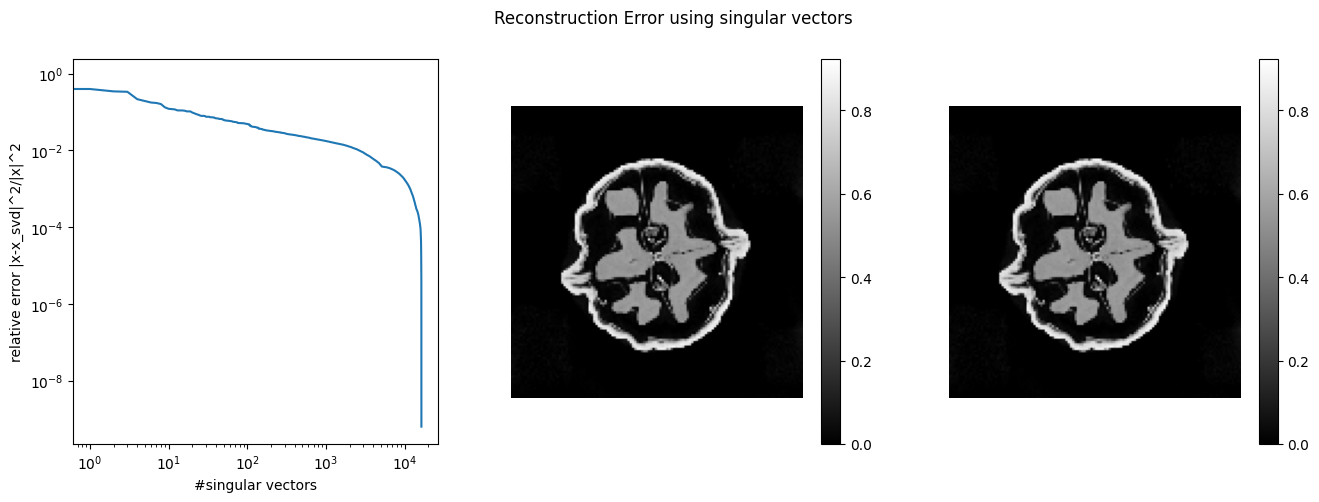

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

fig.suptitle("Reconstruction Error using singular vectors")
ax1.loglog(rel_errors)
ax1.set_xlabel("#singular vectors")
ax1.set_ylabel("relative error |x-x_svd|^2/|x|^2")

im = ax2.imshow(x_svd.reshape(128,128).detach().cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax2)
ax2.axis("off")

im = ax3.imshow(x[0,0].detach().cpu().numpy(), cmap="gray")
fig.colorbar(im, ax=ax3)
ax3.axis("off")

plt.show()